# What does this project do?
1. Extracts international common stock market movements among developed countries
2. Finds the countries with more unique stock market movements
3. Constructs a predictable stock portfolio
4. Examined in-sample and out-of-sample forecast performance
5. Proposed a trading strategy and beats the market

# Key Findings
1. The dynamic factor model is a dimensionality reduction method which I applied for generating a good international stock market indicator.
2. The stock markets in Greece and Germany are the most influential markets. France and Germany follow closely with the international common stock movement, yet Japan and Greece have their unique movements.
3. We are able to construct predictable stock portfolio according to the factor loadings.
4. The in-sample and out-of-sample prediction performance are good.
5. The proposed trading strategy beats the market.
6. The value of suggested portfolio grows by 16% when the market grows by only 4%. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# The raw data is the monthly stock indexes of 10 developed countries. The data starts at Aug. 1997 and ends at Sep. 2015.
# The index data has unit root, so the first difference is taken. Therefore, the data analyzed is stock returns.
data = pd.read_csv('stock_data.csv')
data.date = pd.to_datetime(data.date)
country_names = ['US', 'JP', 'GB', 'DE', 'FR', 'IT', 'CA', 'ES', 'PT', 'GR']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. The International Common Stock Indicator

We are able to observe the stock market movements of individual countries, but not their common movement. Therefore, I utilized dynamic factor model, which is capable for extracting the unobservable information from the observable data. In addition, it is also a tool for dimensionality reduction, and the extracted factor is the representative common movement of these markets. The dynamic factor model could be written in state space representation

$Y_t = c + \Lambda F_t + u_t, \ \ u_t \sim N(0,\Sigma)$

$F_t = \alpha + \beta_1 F_{t-1} + \dots + \beta_p F_{t-p} + \epsilon_t,\ \ \epsilon_t \sim N(0,I)$

where $Y_t$ is observable data, which is the monthly stock returns; $F_t$ is the factor, which represents the unobservable stock market common movement. 

In [2]:
# Dynamic factor model is used for extracting the stock market common movements
sm.tsa.DynamicFactor.endog_names = country_names
endog = data.loc[:,'US':'GR'].values
model = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=1)
initial_res = model.fit(method='powell', disp=False)
result = model.fit(initial_res.params, disp=False)

The factor extracted by the dynamic factor model represents the common movements of international stock markets. Thus, it serves as a good indicator of global financial condition. The following figure illustrates the movement of the factor, which falls when major global financial crises happen. The shaded area represents the recession periods in the US, which is also consistent with the time when the factor drops.

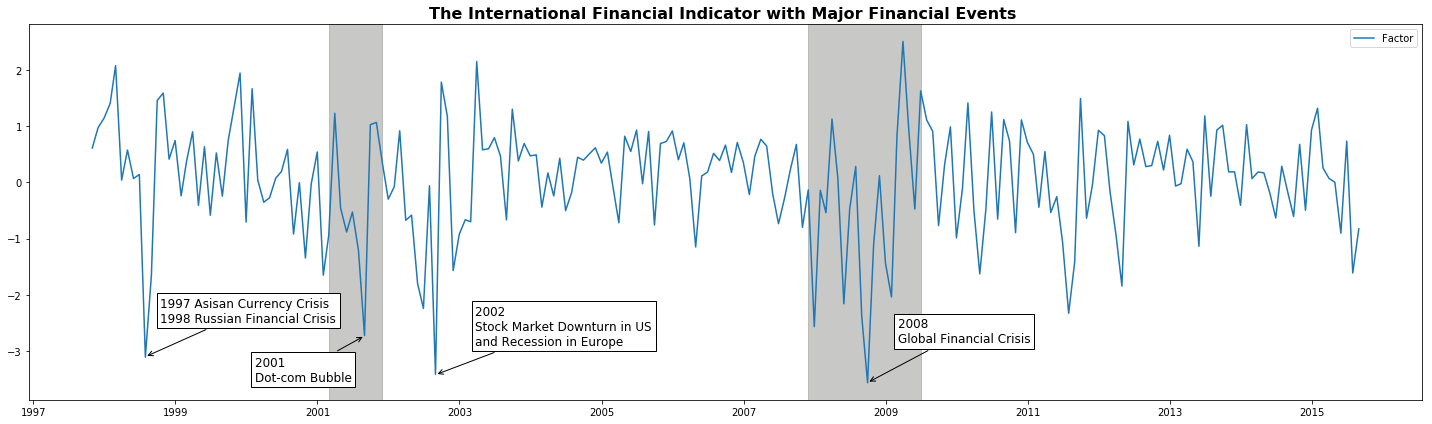

In [3]:
fig=plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
plt.plot(data['date'],-result.factors.filtered[0], label = 'Factor')
ax.axvspan('2001-03-01', '2001-11-30', color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan('2007-12-01', '2009-06-30', color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.set_title('The International Financial Indicator with Major Financial Events ', fontsize=16, fontweight='demi')

bbox_props = dict(boxstyle="square, pad=0.3", fc='w', ec="k", lw=1)
ax.annotate('1997 Asisan Currency Crisis\n1998 Russian Financial Crisis',
            fontsize=12,
            xy=('1998-07-31', -3.1),  
            xycoords='data',
            xytext=(15, 35),      
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), bbox=bbox_props) 

ax.annotate('2001 \nDot-com Bubble',
            fontsize=12,
            xy=('2001-08-31', -2.73),  
            xycoords='data',
            xytext=(-110, -45),      
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), bbox=bbox_props) 

ax.annotate('2002 \nStock Market Downturn in US\nand Recession in Europe',
            fontsize=12,
            xy=('2002-08-31', -3.42),  
            xycoords='data',
            xytext=(40, 30),      
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), bbox=bbox_props) 

ax.annotate('2008 \nGlobal Financial Crisis',
            fontsize=12,
            xy=('2008-09-30', -3.56),  
            xycoords='data',
            xytext=(30, 40),      
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), bbox=bbox_props) 
 
plt.legend()
plt.tight_layout()

The following table presents the summary of the dynamic factor model results.

# 2. The Influential Countries and Countries with Unique Movements

The result of dynamic factor model is estimated as the following table. 

                                                Statespace Model Results                                                
Dep. Variable:     ['US', 'JP', 'GB', 'DE', 'FR', 'IT', 'CA', 'ES', 'PT', 'GR']   No. Observations:                  215
Model:                                        DynamicFactor(factors=1, order=1)   Log Likelihood               -5757.146
Date:                                                          Mon, 23 Jul 2018   AIC                          11556.291
Time:                                                                  10:01:43   BIC                          11627.075
Sample:                                                                       0   HQIC                         11584.891
                                                                          - 215                                         
Covariance Type:                                                            opg                                         
                    coef    std 

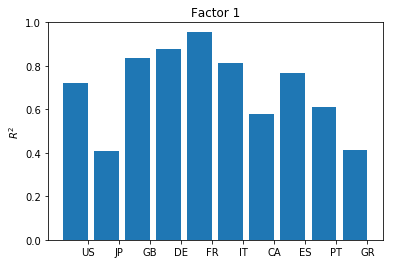

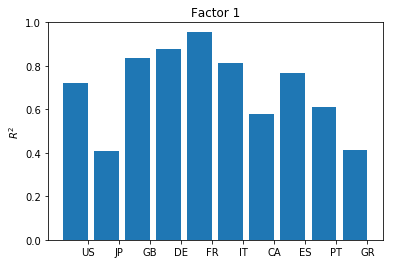

In [4]:
print(result.summary(separate_params=False))
result.plot_coefficients_of_determination(endog_labels = country_names)

The factor loadings indicate the countries' contribution to the international common stock movement. It is shown that Greece and Germany are the most influential countries. According to the coefficient of determination, The stock markets in France and Germany follow closely with the common movement, and the stock markets in Japan and Greece have their unique movements. 

# 3. Constructing Predictable Portfolio and In-Sample Prediction

The factor follows an autoregression process with AR(1) coefficient 0.1809, which is significantly different from 0. It suggests the factor have predictive power. Therefore, I constructed a predictable international stock portfolio with the factor loadings as the weights of each country in the portfolio. 

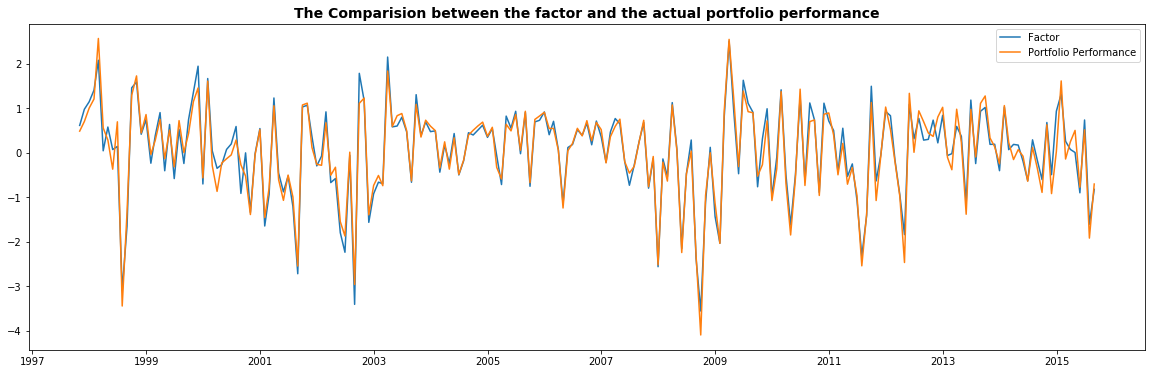

In [5]:
portfolio = np.dot(data.iloc[:,1:11],result.params[0:10]) / result.params[0:10].sum()
portfolio = portfolio / portfolio.std()

fig_test=plt.figure(figsize=(20,6))
plt.title('The Comparision between the factor and the actual portfolio performance', fontsize=14, fontweight='demi')
plt.plot(data['date'], -result.factors.filtered[0], label = 'Factor')
plt.plot(data['date'], portfolio, label = 'Portfolio Performance')
plt.legend()
plt.show()

As shown in the figure above, the factor has proven predictive power for the stock portfolio.

# 4. Out-of-Sample Prediction and Trading Strategy
The out-of-sample prediction performance is examed as the follows. In addition, a trading strategy is suggested according to the predicted result, and it is proven to beat the market. 

In [20]:
# The out-of-sample prediction is performed on 20% of the data, which is about 2.5 years

fore_test = []      # The out-of-sample predicted result
Unit = 1            # Initial portfolio units held
Value_Mkt = [1]     # Initial value of the portfolio in the market
Value_Invt = [1]    # The total value of the investor, either as the portifolio or as cash
Cash = 0            # After selling the portfolio, hold the cash
hold = True         # Whether the portfolio is currently held 

# The iteration updates the prediction when new data comes in
for i in data.date:
    if i>=pd.to_datetime('2012-03-31'):
        endog_pre = data.loc[:data.index[data.date==i][0]+1,'US':'GR'].values
        model_pre = sm.tsa.DynamicFactor(endog_pre, k_factors=1, factor_order=1)
        initial_res = model_pre.fit(method='powell', disp=False)
        result_test = model_pre.fit(initial_res.params, disp=False)
        temp_fore = result_test.forecast()
        if fore_test == []:         # The following do the trading and record the value of the portfolio
            fore_test = temp_fore[0,0]
        else:
            fore_test = np.append(fore_test, temp_fore[0,0])
        if temp_fore[0,0] > 0:      # When predicted stock price goes up
            if not hold:       # If not holding the portifolio, buy it; If holding the portfolio, keep it.
                Unit = Cash / Value_Mkt[-1]
                Cash = 0
                hold = True
        else:                       # When predicted stock price goes down
            if hold:                # If holding the portifolio, sell it; Otherwise, do nothing.
                Cash = Unit * Value_Mkt[-1]
                Unit = 0
                hold = False
        if i != pd.to_datetime('2015-08-31'):
            Value_Invt.append(max(Unit * Value_Mkt[-1], Cash)) # update the value of the investor
            Value_Curr = Value_Mkt[-1] * (1 + portfolio[data.index[data.date==i][0]+1] * 0.01)
            Value_Mkt.append(Value_Curr) # update the true market value

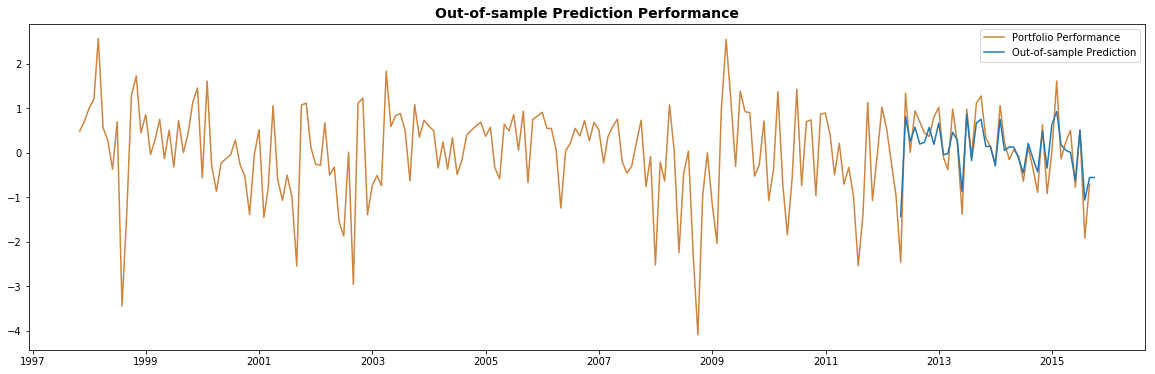

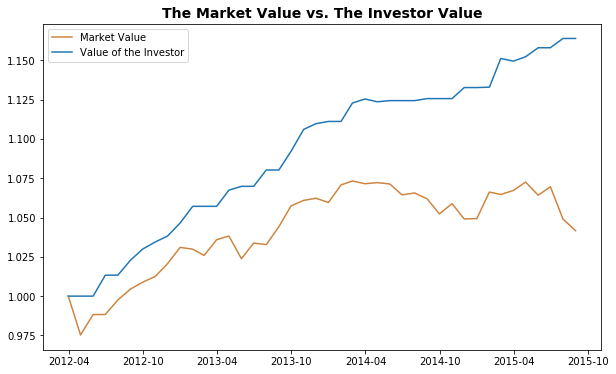

The value of the market grows by 4.2 %, and the value of the suggested portifolio following the proposed trading strategy grows by 16.0 %


In [30]:
fig_test=plt.figure(figsize=(20,6))
plt.title('Out-of-sample Prediction Performance', fontsize=14, fontweight='demi')
plt.plot(data['date'], portfolio, color = 'peru', label = 'Portfolio Performance')
plt.plot(pd.Series.append(data.date[-41:], pd.Series('2015-09-30')), fore_test, label = 'Out-of-sample Prediction')
plt.legend()
plt.show()

fig_test=plt.figure(figsize=(10,6))
plt.title('The Market Value vs. The Investor Value', fontsize=14, fontweight='demi')
plt.plot(data['date'][-42:], Value_Mkt, color = 'peru', label = 'Market Value')
plt.plot(data['date'][-42:], Value_Invt, label = 'Value of the Investor' )
plt.legend()
plt.show()

print('The value of the market grows by', round((Value_Mkt[-1]-1), 3)*100, 
      '%, and the value of the suggested portifolio following the proposed trading strategy grows by'
      , round(Value_Invt[-1]-1, 2)*100, '%')